In [127]:
import pandas as pd
import numpy as np
import gspread
from pydata_google_auth import get_user_credentials
from google.cloud import bigquery
from pycaret.clustering import *

project_id = 'ledger-fcc1e'
creds = get_user_credentials([
    'https://www.googleapis.com/auth/cloud-platform', 
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive',
])
client = bigquery.Client(project=project_id, credentials=creds)

gc = gspread.authorize(creds) 
pull_data = lambda query: client.query(query).result().to_dataframe()
get_worksheet = lambda key, name: gc.open_by_key(key).worksheet(name)

In [128]:
query =\
'''
-- query for clustering v2
WITH users AS (
  SELECT DISTINCT user_id
  FROM `ledger-fcc1e.dg_buku_trnsfmd.ppm_table`
  WHERE last_transaction_date >= '2023-04-01'
)

, loyalty AS (
  SELECT 
    user_id, 
    date_,
    kyc_tier,
    loyalty_tier,
  FROM `ledger-fcc1e.trb_mxg_reports.loyalty_ssot`
  WHERE 
    date_ IN ('2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01')
    AND kyc_tier <> 'NON_KYC'
)

, campaigns AS (
  SELECT
    user_id,
    DATE_ADD(DATE_TRUNC(date_, MONTH), INTERVAL 1 MONTH) AS date_,
    SUM(daily_OTHER_saldo) AS M1_campaign_saldo
  FROM `ledger-fcc1e.trb_mxg_reports.loyalty_ssot`
  WHERE date_ BETWEEN '2023-04-01' AND '2023-07-31'
  GROUP BY 1, 2
)


, payments AS (
  SELECT
    user_id,
    DATE_ADD(DATE_TRUNC(transaction_date, MONTH), INTERVAL 1 MONTH) AS date_,
    -- TRANSACTIONS
    COUNT(DISTINCT IF(product_type IN ('Payment In', 'Payment Out'), transaction_id, NULL)) AS M1_core_count,
    COUNT(DISTINCT IF(product_type IN ('PPOB'), transaction_id, NULL)) AS M1_ppob_count,
    -- CUSTOMER
    COUNT(DISTINCT IF(product_type = 'PPOB', beneficiaryid_ppob, NULL)) + COUNT(DISTINCT IF(product_type = 'Payment Out', destination_bank_account_number, NULL)) AS total_customer,
  FROM `ledger-fcc1e.payment_reports.payments_ssot`
  WHERE
    status_v2 = 'COMPLETED'
    AND transaction_date BETWEEN '2023-04-01' AND '2023-07-31'
  GROUP BY 1, 2
)

, accountings AS (
  SELECT DISTINCT
    DATE_ADD(DATE_TRUNC(DATE(trans_createdAt), MONTH), INTERVAL 1 MONTH) AS date_,
    createdByUser AS user_id,
    COUNT(DISTINCT transactionId) AS M1_acc_count
  FROM `ledger-fcc1e.bukuwarung_analytics.accounting_transactions_table_db`
  WHERE DATE(trans_createdAt) BETWEEN '2023-04-01' AND '2023-07-31'
  GROUP BY 1, 2
)

-- //this is a bit inefficient since i load the same table twice...
-- //open to idea on how to do it better
-- , banks AS (
--   SELECT DISTINCT
--     user_id,
--     date_,
--     ARRAY_AGG(money_in_channel) OVER(PARTITION BY user_id, date_ ORDER BY cnt_ DESC) [OFFSET(0)] AS main_funding_bank
--   FROM (
--     SELECT 
--       user_id,
--       DATE_ADD(DATE_TRUNC(transaction_date, MONTH), INTERVAL 1 MONTH) AS date_,
--       money_in_channel,
--       COUNT(*) AS cnt_
--     FROM `ledger-fcc1e.payment_reports.payments_ssot`
--     WHERE
--       status_v2 = 'COMPLETED'
--       AND product_type IN ('SALDO')
--       AND transaction_date BETWEEN '2023-04-01' AND '2023-07-01'
--     GROUP BY 1, 2, 3
--   )
-- )

, referrals AS (
  SELECT 
    referrer AS user_id,
    date_,
    COUNT(DISTINCT referee) AS referee_count
  FROM `ledger-fcc1e.trb_mxg_reports.referral_ssot` 
  WHERE date_ IN ('2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01')
  GROUP BY 1, 2
)

, profiles AS (
  SELECT DISTINCT
    user_id,
    acquisition_channel,
    user_segment_sub_bucket,
    first_user_date,
    first_any_payment_date,
    first_transaction_date
  FROM `ledger-fcc1e.dg_buku_trnsfmd.user_profile_datamart`
)

, impressions AS (
  SELECT
    SUBSTR(phone_number, 4) AS user_id,
    DATE_ADD(DATE_TRUNC(notification_date, MONTH), INTERVAL 1 MONTH) AS date_,
    SUM(pn_count) AS send_count,
    SUM(impressions_count) AS impressions_count,
    SUM(read_count) AS read_count,
    COUNT(DISTINCT user_activated) AS activated_count,
    COUNT(DISTINCT user_converted) AS converted_count
  FROM `ledger-fcc1e.crm_reports.crm_notification_service_campaign_performance`
  WHERE 
    notification_date BETWEEN '2023-04-01' AND '2023-08-31'
    AND objective_code IN ('PAY_GEN', 'PAY_POUT', 'PPOB_PRE', 'PPOB_GEN', 'PAY', 'PPOB', 'SAL_TOPUP')
  GROUP BY 1, 2
)

SELECT DISTINCT
  user_id,
  date_,
  kyc_tier,
  loyalty_tier,
  (CASE WHEN M1_core_count IS NULL AND date_ >= first_any_payment_date THEN 0 ELSE M1_core_count END) AS M1_core_count,
  (CASE WHEN M1_ppob_count IS NULL AND date_ >= first_any_payment_date THEN 0 ELSE M1_ppob_count END) AS M1_ppob_count,
  (CASE WHEN M1_acc_count IS NULL AND date_ >= first_transaction_date THEN 0 ELSE M1_acc_count END) AS M1_acc_count,
  M1_campaign_saldo,
  -- (CASE WHEN M1_core_count > 0 THEN 1 ELSE M1_core_count END) AS M1_core_count,
  -- (CASE WHEN M1_ppob_count > 0 THEN 1 ELSE M1_ppob_count END) AS M1_ppob_count,
  -- (CASE WHEN M1_acc_count > 0 THEN 1 ELSE M1_acc_count END) AS M1_acc_count,
  -- (CASE WHEN M1_campaign_saldo > 0 THEN 1 ELSE M1_campaign_saldo END) AS M1_campaign_saldo,
  total_customer,
  -- IFNULL(
  --   IFNULL(
  --     LAST_VALUE(main_funding_bank IGNORE NULLS) OVER(PARTITION BY user_id ORDER BY date_ ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW),
  --     FIRST_VALUE(main_funding_bank IGNORE NULLS) OVER(PARTITION BY user_id ORDER BY date_ ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING)
  --   ),
  --   NULL
  -- ) AS main_funding_bank,
  (CASE WHEN referee_count > 0 THEN 1 ELSE 0 END) AS is_referrer,
  acquisition_channel,
  user_segment_sub_bucket,
  DATE_DIFF(date_, first_user_date, DAY) AS age_on_platform_days,
  CASE WHEN send_count > 0 THEN 1 ELSE IFNULL(send_count, 0) END AS is_send_m1,
  CASE WHEN impressions_count > 0 THEN 1 ELSE IFNULL(impressions_count, 0) END AS is_imp_m1,
  CASE WHEN read_count > 0 THEN 1 ELSE IFNULL(read_count, 0) END AS is_read_m1,
  IFNULL(activated_count, 0) AS is_act_m1,
  IFNULL(converted_count, 0) AS is_conv_m1
FROM users -- active in last 12 months
INNER JOIN loyalty USING (user_id) -- needs to be atleast KYC
LEFT JOIN payments USING (user_id, date_) -- get Q2 transaction data
-- LEFT JOIN banks USING (user_id, date_)
LEFT JOIN referrals USING (user_id, date_)
LEFT JOIN impressions USING (user_id, date_)
LEFT JOIN accountings USING (user_id, date_)
LEFT JOIN campaigns USING (user_id, date_)
LEFT JOIN profiles USING (user_id)
WHERE date_ < '2023-09-01'
ORDER BY 1, 2

'''
raw = client.query(query).result().to_dataframe()
raw.to_pickle('data/raw_data_v2.pkl')
raw = pd.read_pickle('data/raw_data_v2.pkl')

# use m1 transaction data
# get profile features which are available to most users
# include more users (who have done kyc and are active in last 12 months)
# check WA impressions and clicks
# in payments_ssot check the bank account when user topup saldo -- main_funding_bank
# can estimate customers as well using payments data
# 


In [129]:
# -- QUERY TO GET IMPRESSIONS COUNT
imp_query =\
'''
WITH users AS (
  SELECT DISTINCT user_id
  FROM `ledger-fcc1e.dg_buku_trnsfmd.ppm_table`
  WHERE last_transaction_date >= '2023-04-01'
)

, loyalty AS (
  SELECT user_id, date_
  FROM `ledger-fcc1e.trb_mxg_reports.loyalty_ssot`
  WHERE 
    date_ IN ('2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01')
    AND kyc_tier <> 'NON_KYC'
)

, impressions AS (
  SELECT
    SUBSTR(phone_number, 4) AS user_id,
    DATE_TRUNC(notification_date, MONTH) AS date_,
    SUM(pn_count) AS send_count,
    SUM(impressions_count) AS impressions_count,
    SUM(read_count) AS read_count,
    COUNT(DISTINCT user_activated) AS activated_count,
    COUNT(DISTINCT user_converted) AS converted_count
  FROM `ledger-fcc1e.crm_reports.crm_notification_service_campaign_performance`
  WHERE 
    notification_date BETWEEN '2023-05-01' AND '2023-08-31'
    AND objective_code IN ('PAY_GEN', 'PAY_POUT', 'PPOB_PRE', 'PPOB_GEN', 'PAY', 'PPOB', 'SAL_TOPUP')
  GROUP BY 1, 2
)

SELECT
  user_id,
  date_,
  CASE WHEN send_count > 0 THEN 1 ELSE IFNULL(send_count, 0) END AS send_count,
  CASE WHEN impressions_count > 0 THEN 1 ELSE IFNULL(impressions_count, 0) END AS impressions_count,
  CASE WHEN read_count > 0 THEN 1 ELSE IFNULL(read_count, 0) END AS read_count,
  IFNULL(activated_count, 0) AS activated_count,
  IFNULL(converted_count, 0) AS conveted_count
FROM users
INNER JOIN loyalty USING (user_id)
LEFT JOIN impressions USING (user_id, date_)
WHERE send_count IS NOT NULL
'''
imp = client.query(imp_query).result().to_dataframe()
imp.to_pickle('data/raw_imp_v2.pkl')
imp = pd.read_pickle('data/raw_imp_v2.pkl')

In [176]:
res.groupby([ 'date_', 'Cluster']).agg('mean')

M1_core_count  M1_ppob_count  M1_acc_count  \
date_      Cluster                                                 
2023-05-01 Cluster 0       1.118025       1.265689      0.288245   
           Cluster 1       4.197311       3.210938        0.3468   
           Cluster 2       0.041951       1.911115      1.539186   
           Cluster 3       0.095612       1.753487      1.447575   
2023-06-01 Cluster 0       0.962543       1.162998      0.302222   
           Cluster 1       3.966111       3.293823      0.381058   
           Cluster 2       0.042449        2.19687       2.34342   
           Cluster 3       0.138479       1.941969      1.741979   
2023-07-01 Cluster 0       0.852087       0.983285      0.301901   
           Cluster 1        3.83735       3.187949      0.411558   
           Cluster 2       0.065596       2.172376      1.768747   
           Cluster 3       0.333912       1.867059      1.366542   
2023-08-01 Cluster 0       1.398514       1.750191      0.268824   
           Cluster 1       3.821463       3.325205      0.409095   
           Cluster 2       0.032136       2.354108      1.761856   
           Cluster 3       0.227586       2.238121      1.579502   

                      M1_campaign_saldo  total_customer  is_referrer  \
date_      Cluster                                                     
2023-05-01 Cluster 0           0.089816        18.13484      0.03244   
           Cluster 1            2.49189      200.569165     0.221818   
           Cluster 2           0.241192        13.69484     0.033282   
           Cluster 3           0.314192       12.155361     0.046129   
2023-06-01 Cluster 0           0.044779       17.494509     0.032923   
           Cluster 1           0.880949      151.986147     0.196552   
           Cluster 2           0.003672       13.151974     0.017834   
           Cluster 3           0.004394       13.232323     0.041618   
2023-07-01 Cluster 0           0.146038       17.216503     0.047875   
           Cluster 1           3.849115      135.913758     0.188582   
           Cluster 2           0.022909       12.772804     0.035605   
           Cluster 3           0.060762       14.145326     0.064249   
2023-08-01 Cluster 0           0.086703       23.161414       0.0614   
           Cluster 1           1.997573      151.479731     0.205653   
           Cluster 2            0.00147       14.132486     0.037816   
           Cluster 3            0.01232       17.478261     0.076233   

                      age_on_platform_days  send_count  impressions_count  \
date_      Cluster                                                          
2023-05-01 Cluster 0            270.463895         1.0           0.892106   
           Cluster 1            417.642424         1.0           0.908485   
           Cluster 2             385.23408         1.0           0.897937   
           Cluster 3            551.144975         1.0           0.912136   
2023-06-01 Cluster 0            279.196037         1.0           0.876213   
           Cluster 1             444.34181         1.0           0.912069   
           Cluster 2            340.012527         1.0           0.915499   
           Cluster 3            577.745665         1.0           0.915607   
2023-07-01 Cluster 0            368.259384         1.0           0.869872   
           Cluster 1            516.802203         1.0           0.899078   
           Cluster 2            378.649847         1.0           0.895422   
           Cluster 3             611.55916         1.0           0.899491   
2023-08-01 Cluster 0            381.414809         1.0           0.871725   
           Cluster 1            541.440717         1.0           0.893153   
           Cluster 2            390.638827         1.0           0.890597   
           Cluster 3            656.222934         1.0           0.894939   

                      read_count  activated_count  conveted_count  
date_      Cluster                           

In [130]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202906 entries, 0 to 202905
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   user_id                  202906 non-null  object
 1   date_                    202906 non-null  dbdate
 2   kyc_tier                 202906 non-null  object
 3   loyalty_tier             202906 non-null  object
 4   M1_core_count            148411 non-null  Int64 
 5   M1_ppob_count            148411 non-null  Int64 
 6   M1_acc_count             201381 non-null  Int64 
 7   M1_campaign_saldo        202751 non-null  Int64 
 8   total_customer           87932 non-null   Int64 
 9   is_referrer              202906 non-null  Int64 
 10  acquisition_channel      202906 non-null  object
 11  user_segment_sub_bucket  202906 non-null  object
 12  age_on_platform_days     202906 non-null  Int64 
 13  is_send_m1               202906 non-null  Int64 
 14  is_imp_m1           

In [253]:
std_core = np.std(raw['M1_core_count'])
std_ppob = np.std(raw['M1_ppob_count'])
std_acc = np.std(raw['M1_acc_count'])
std_saldo = np.std(raw['M1_campaign_saldo'])
std_age = np.std(raw['age_on_platform_days'])

df =\
(
    raw
    .assign(
        # referee_count = lambda x: x.referee_count.fillna(0),
        date_ = lambda x: x.date_.astype(str),
        index_ = lambda x: x.user_id + " " + x.date_,

        # M1_core_count = lambda x: x.M1_core_count/std_core,
        # M1_acc_count = lambda x: x.M1_acc_count/std_acc,
        # M1_ppob_count = lambda x: x.M1_ppob_count/std_ppob,
        # M1_campaign_saldo = lambda x: x.M1_campaign_saldo/std_saldo,
        # age_on_platform_days = lambda x: x.age_on_platform_days/std_age,
        M1_core_count = lambda x: np.log1p(x.M1_core_count),
        M1_ppob_count = lambda x: np.log1p(x.M1_ppob_count),
        M1_acc_count = lambda x: np.log1p(x.M1_acc_count),
        M1_campaign_saldo = lambda x: np.log1p(x.M1_campaign_saldo),
        age_on_platform_days = lambda x: np.log1p(x.age_on_platform_days),

        is_send_m1 = lambda x: x.is_send_m1.fillna(0),
        is_imp_m1 = lambda x: x.is_imp_m1.fillna(0),
        is_read_m1 = lambda x: x.is_read_m1.fillna(0),
        is_act_m1 = lambda x: x.is_act_m1.fillna(0),
        is_conv_m1 = lambda x: x.is_conv_m1.fillna(0),
    )
    # .drop(columns=['user_id', 'date_', 'is_send_m1', 'is_imp_m1', 'is_read_m1', 'is_act_m1', 'is_conv_m1'])
    # .drop(columns=['user_id', 'date_', 'M1_core_count', 'M1_acc_count', 'M1_ppob_count'])
    .drop(columns=['user_id', 'date_'])
    .set_index('index_')
)
df

,kyc_tier,loyalty_tier,M1_core_count,M1_ppob_count,M1_acc_count,M1_campaign_saldo,total_customer,is_referrer,acquisition_channel,user_segment_sub_bucket,age_on_platform_days,is_send_m1,is_imp_m1,is_read_m1,is_act_m1,is_conv_m1
index_,,,,,,,,,,,,,,,,
1161895687 2023-06-01,ADVANCED,Bronze,0.0,0.693147,1.791759,0.0,1,0,Organic Acquisition,pureO2O-PA+PP,5.736572,0,0,0,0,0
1161895687 2023-07-01,ADVANCED,Bronze,0.0,1.098612,0.0,0.0,2,0,Organic Acquisition,pureO2O-PA+PP,5.828946,0,0,0,0,0
1161895687 2023-08-01,ADVANCED,Bronze,0.0,3.135494,3.526361,0.0,16,0,Organic Acquisition,pureO2O-PA+PP,5.916202,0,0,0,0,0
8111010474 2023-05-01,ADVANCED,Bronze,0.0,0.0,0.693147,0.0,<NA>,0,Paid Acquisition,UNKNOWN,5.988961,0,0,0,0,0
8111010474 2023-06-01,ADVANCED,Bronze,0.0,0.0,0.0,0.0,<NA>,0,Paid Acquisition,UNKNOWN,6.063785,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8999999365 2023-08-01,SUPREME,Gold,0.0,5.365976,0.0,0.0,158,0,Offline Acquisition,pureO2O-PAonly,6.426488,1,1,0,1,0
8999999557 2023-05-01,SUPREME,Diamond,6.747587,1.386294,0.0,8.2943,437,0,Offline Acquisition,pureO2O-PAonly,6.152733,0,0,0,0,0
8999999557 2023-06-01,SUPREME,Diamond,6.602588,0.0,0.0,7.601402,318,0,Offline Acquisition,pureO2O-PAonly,6.216606,1,1,1,1,1


In [254]:
df.describe()

,M1_core_count,M1_ppob_count,M1_acc_count,M1_campaign_saldo,total_customer,is_referrer,age_on_platform_days,is_send_m1,is_imp_m1,is_read_m1,is_act_m1,is_conv_m1
count,148411.0,148411.0,201381.0,202751.0,87932.0,202906.0,202906.0,202906.0,202906.0,202906.0,202906.0,202906.0
mean,0.858504,1.215311,1.380296,0.214714,38.775508,0.052611,5.731672,0.433777,0.388451,0.30354,0.177112,0.097863
std,1.558698,1.702584,2.013849,1.298238,88.932016,0.223255,1.215704,0.495596,0.487399,0.459787,0.381764,0.29713
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,2.0,0.0,4.990433,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,11.0,0.0,6.244167,0.0,0.0,0.0,0.0,0.0
75%,1.098612,2.397895,2.833213,0.0,38.0,0.0,6.60665,1.0,1.0,1.0,0.0,0.0
max,8.2247,8.548886,9.481817,12.551437,2907.0,1.0,7.26473,1.0,1.0,1.0,1.0,1.0


In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202906 entries, 1161895687 2023-06-01 to 8999999557 2023-08-01
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   kyc_tier                 202906 non-null  object 
 1   loyalty_tier             202906 non-null  object 
 2   M1_core_count            148411 non-null  Float64
 3   M1_ppob_count            148411 non-null  Float64
 4   M1_acc_count             201381 non-null  Float64
 5   M1_campaign_saldo        202751 non-null  Float64
 6   total_customer           87932 non-null   Int64  
 7   is_referrer              202906 non-null  Int64  
 8   acquisition_channel      202906 non-null  object 
 9   user_segment_sub_bucket  202906 non-null  object 
 10  age_on_platform_days     202906 non-null  Float64
 11  is_send_m1               202906 non-null  Int64  
 12  is_imp_m1                202906 non-null  Int64  
 13  is_read_m1               2029

In [256]:
s = setup(
    df, 
    normalize=False, 
    ignore_features=['user_id'],
    use_gpu = True,
    session_id = 123)

,Description,Value
0,Session id,123
1,Original data shape,"(202906, 16)"
2,Transformed data shape,"(202906, 33)"
3,Ignore features,1
4,Ordinal features,1
5,Numeric features,12
6,Categorical features,4
7,Rows with missing values,56.7%
8,Preprocess,True
9,Imputation type,simple


In [257]:
kmeans = create_model('kmeans', num_clusters=4)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.8235,295060.0801,0.5209,0,0,0


In [258]:
# plot_model(kmeans, 'tsne')

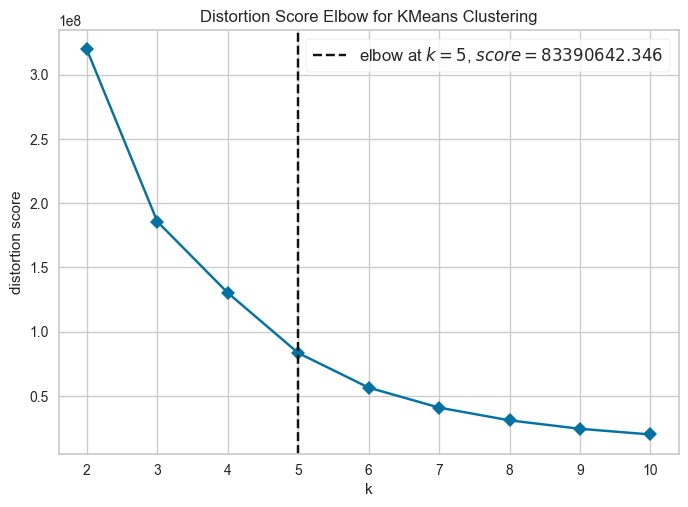

In [259]:
plot_model(kmeans, plot = 'elbow')

In [260]:
# plot_model(kmeans, plot = 'distribution')

In [261]:
imp_df =\
(
    imp
    .assign(
        date_ = lambda x: x.date_.astype(str)
    )
)

In [262]:
imp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84122 entries, 0 to 84121
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            84122 non-null  object
 1   date_              84122 non-null  object
 2   send_count         84122 non-null  Int64 
 3   impressions_count  84122 non-null  Int64 
 4   read_count         84122 non-null  Int64 
 5   activated_count    84122 non-null  Int64 
 6   conveted_count     84122 non-null  Int64 
dtypes: Int64(5), object(2)
memory usage: 4.9+ MB


In [263]:
imp_df.describe()

,send_count,impressions_count,read_count,activated_count,conveted_count
count,84122.0,84122.0,84122.0,84122.0,84122.0
mean,1.0,0.889862,0.679584,0.411402,0.221333
std,0.0,0.313063,0.466639,0.492091,0.415147
min,1.0,0.0,0.0,0.0,0.0
25%,1.0,1.0,0.0,0.0,0.0
50%,1.0,1.0,1.0,0.0,0.0
75%,1.0,1.0,1.0,1.0,0.0
max,1.0,1.0,1.0,1.0,1.0


In [264]:
res =\
(
    assign_model(kmeans)
    .reset_index()
    .assign(
        user_id = lambda x: x.index_.str.split(" ", expand=False).str[0],
        date_ = lambda x: x.index_.str.split(" ", expand=False).str[1]
    )
    .drop(columns=['index_'])
    .merge(imp_df, how='right', on=['user_id', 'date_'])
    # .assign(
    #     impressions_count = lambda x: x.impressions_count.fillna(0),
    #     read_count = lambda x: x.read_count.fillna(0),
    # )
)

In [265]:
res.describe()

,M1_core_count,M1_ppob_count,M1_acc_count,M1_campaign_saldo,total_customer,is_referrer,age_on_platform_days,is_send_m1,is_imp_m1,is_read_m1,is_act_m1,is_conv_m1,send_count,impressions_count,read_count,activated_count,conveted_count
count,77678.0,77678.0,83601.0,84015.0,62500.0,84122.0,84122.0,84122.0,84122.0,84122.0,84122.0,84122.0,84122.0,84122.0,84122.0,84122.0,84122.0
mean,1.209894,1.836401,0.872669,0.451557,44.314624,0.064133,5.336371,0.800706,0.719312,0.584092,0.399087,0.228014,1.0,0.889862,0.679584,0.411402,0.221333
std,1.761711,1.841671,1.726326,1.857446,95.813692,0.244991,1.369035,0.399472,0.449338,0.492881,0.489714,0.419554,0.0,0.313063,0.466639,0.492091,0.415147
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,3.0,0.0,4.382027,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
50%,0.0,1.386294,0.0,0.0,13.0,0.0,5.863631,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
75%,2.302585,3.401197,0.693147,0.0,45.0,0.0,6.461468,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
max,8.2247,8.548886,9.481817,12.551437,2907.0,1.0,7.257708,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [266]:
res.groupby([ 'date_', 'Cluster']).agg('mean')

M1_core_count  M1_ppob_count  M1_acc_count  \
date_      Cluster                                                 
2023-05-01 Cluster 0       0.744014       1.499131      0.803013   
           Cluster 1       5.141524       4.110206      0.236834   
           Cluster 2       6.659688       4.423418      0.014748   
           Cluster 3       3.685073       3.686008      0.449878   
2023-06-01 Cluster 0       0.784889       1.527556      1.289961   
           Cluster 1       4.806022       4.837103      0.239571   
           Cluster 2        6.53989       4.748178      0.159957   
           Cluster 3        3.82348       3.769136      0.444867   
2023-07-01 Cluster 0       0.881658       1.398017      0.686474   
           Cluster 1       5.274882       4.443011      0.285772   
           Cluster 2       6.408549       4.904624      0.247567   
           Cluster 3       3.848307       3.769259      0.466845   
2023-08-01 Cluster 0       1.067112       2.029749      0.870643   
           Cluster 1       5.150899       4.561671       0.34419   
           Cluster 2       6.613289       4.576848      0.144348   
           Cluster 3       3.797569       3.857459      0.480226   

                      M1_campaign_saldo  total_customer  is_referrer  \
date_      Cluster                                                     
2023-05-01 Cluster 0           0.254635        15.55904     0.040431   
           Cluster 1           3.111873      412.515152     0.255892   
           Cluster 2           5.898593     1014.553191     0.382979   
           Cluster 3           1.486666      158.006876     0.168959   
2023-06-01 Cluster 0           0.074589        17.06087     0.033842   
           Cluster 1           0.797912      415.583691     0.240343   
           Cluster 2           2.116124     1080.692308     0.346154   
           Cluster 3           0.496746      148.259342     0.164425   
2023-07-01 Cluster 0           0.419997       19.406781     0.057423   
           Cluster 1           5.925837      410.394737     0.260526   
           Cluster 2            7.18481         1006.92          0.4   
           Cluster 3           3.469125      149.314272     0.179863   
2023-08-01 Cluster 0           0.248247       21.786795     0.071885   
           Cluster 1           3.482503       406.94235     0.283814   
           Cluster 2           6.004476     1119.261538     0.353846   
           Cluster 3           1.577531       150.15018     0.173561   

                      age_on_platform_days  is_send_m1  is_imp_m1  is_read_m1  \
date_      Cluster                                                              
2023-05-01 Cluster 0              5.192493    0.890354   0.803869    0.677355   
           Cluster 1              5.884311    0.468013   0.424242    0.343434   
           Cluster 2              6.184456    0.297872   0.297872    0.234043   
           Cluster 3              5.439422    0.766208   0.694499    0.613949   
2023-06-01 Cluster 0              4.987346    0.693085   0.624257    0.518202   
           Cluster 1              5.778819    0.892704   0.832618    0.746781   
           Cluster 2              5.871197    0.923077   0.884615    0.692308   
           Cluster 3               5.70415      0.7287   0.667414    0.591181   
2023-07-01 Cluster 0              5.429169    0.775404   0.691046    0.534921   
           Cluster 1              6.048763    0.618421   0.573684    0.478947   
           Cluster 2              6.233637        0.54       0.52        0.34   
           Cluster 3              5.912764     0.70479   0.643206    0.548876   
2023-08-01 Cluster 0              5.557505     0.90316   0.808411    0.641586   
           Cluster 1              6.099523    0.988914   0.880266    0.698448   
           Cluster 2              6.203869    0.830769   0.769231    0.553846   
           Cluster 3              5.925652    0.984263   0.892536     0.75045   

                      is_act_m1  is_conv_

In [267]:
res.groupby([ 'date_', 'Cluster']).agg('count')

kyc_tier  loyalty_tier  M1_core_count  M1_ppob_count  \
date_      Cluster                                                           
2023-05-01 Cluster 0     14939         14939          14646          14646   
           Cluster 1       297           297            297            297   
           Cluster 2        47            47             47             47   
           Cluster 3      1018          1018           1018           1018   
2023-06-01 Cluster 0     21866         21866          16182          16182   
           Cluster 1       233           233            233            233   
           Cluster 2        26            26             26             26   
           Cluster 3      1338          1338           1338           1338   
2023-07-01 Cluster 0     23353         23353          23082          23082   
           Cluster 1       380           380            380            380   
           Cluster 2        50            50             50             50   
           Cluster 3      2046          2046           2046           2046   
2023-08-01 Cluster 0     15789         15789          15593          15593   
           Cluster 1       451           451            451            451   
           Cluster 2        65            65             65             65   
           Cluster 3      2224          2224           2224           2224   

                      M1_acc_count  M1_campaign_saldo  total_customer  \
date_      Cluster                                                      
2023-05-01 Cluster 0         14809              14922           11704   
           Cluster 1           297                297             297   
           Cluster 2            47                 47              47   
           Cluster 3          1018               1018            1018   
2023-06-01 Cluster 0         21648              21821           12420   
           Cluster 1           233                233             233   
           Cluster 2            26                 26              26   
           Cluster 3          1338               1338            1338   
2023-07-01 Cluster 0         23250              23324           16252   
           Cluster 1           380                380             380   
           Cluster 2            50                 50              50   
           Cluster 3          2046               2046            2046   
2023-08-01 Cluster 0         15719              15773           13949   
           Cluster 1           451                451             451   
           Cluster 2            65                 65              65   
           Cluster 3          2224               2224            2224   

                      is_referrer  acquisition_channel  \
date_      Cluster                                       
2023-05-01 Cluster 0        14939                14939   
           Cluster 1          297                  297   
           Cluster 2           47                   47   
           Cluster 3         1018                 1018   
2023-06-01 Cluster 0        21866                21866   
           Cluster 1          233                  233   
           Cluster 2           26                   26   
           Cluster 3         1338                 1338   
2023-07-01 Cluster 0        23353                23353   
           Cluster 1          380                  380   
           Cluster 2           50                   50   
           Cluster 3         2046                 2046   
2023-08-01 Cluster 0        15789                15789   
           Cluster 1          451                  451   
           Cluster 2           65                   65   
           Cluster 3         2224                 2224   

                      user_segment_sub_bucket  ...  is_imp_m1  is_read_m1  \
date_      Cluster                             ...                          
2023-05-01 Cluster 0                    14939  ...      14939       14939   
           Cluster 1      